In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
pip install dmba

In [ ]:
from dmba import classificationSummary

Colab environment detected.


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_excel('/content/for_machine_learningdf.xlsx').set_index('customerID')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 7590-VHVEG to 2775-SEFEE
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   seniorCitizen                          5042 non-null   int64  
 1   partner                                5042 non-null   int64  
 2   dependents                             5042 non-null   int64  
 3   tenure                                 5042 non-null   int64  
 4   phoneService                           5042 non-null   int64  
 5   paperlessBilling                       5042 non-null   int64  
 6   monthlyCharges                         5042 non-null   float64
 7   totalCharges                           5042 non-null   float64
 8   gender_Male                            5042 non-null   int64  
 9   multipleLines_True                     5042 non-null   int64  
 10  multipleLines_No phone service         5042 non-null   int64  

# Random Forest

In [ ]:
X = df.drop('churn', axis=1) # including partners
y = df.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

In [ ]:
param_grid = {
    'max_depth': [4, 8, 12, 16, None],
    'min_samples_leaf': [1,4, 6, 10, 14],
    'min_impurity_decrease': [0, 0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5]
}

In [ ]:
rf = RandomForestClassifier(random_state=0)

In [ ]:
rf_grid = GridSearchCV(
    rf, param_grid, cv=5, scoring='recall', n_jobs=-1
)

In [ ]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16, None],
                         'min_impurity_decrease': [0, 0.0001, 0.0005, 0.001,
                                                   0.005, 0.1, 0.5],
                         'min_samples_leaf': [1, 4, 6, 10, 14]},
             scoring='recall')

In [ ]:
class_names= ['no churn', 'churn']

In [ ]:
rf_grid.best_params_

{'max_depth': 12, 'min_impurity_decrease': 0, 'min_samples_leaf': 1}

In [ ]:
rf_grid.score(X_valid, y_valid)

0.5522388059701493

In [ ]:
classificationSummary(y_valid, rf_grid.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7960)

         Prediction
  Actual no churn    churn
no churn      328       43
   churn       60       74


## less interpretable model and worse performance for what I want.

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
gb = GradientBoostingClassifier(
    random_state=0
)

In [ ]:
param_grid = {
    'max_depth': [4, 8, 12, 16, None],
    'min_samples_leaf': [1, 2, 4, 6],
    'learning_rate': [0.1, 0.5, 1]
}

In [ ]:
gb_grid = GridSearchCV(
    gb, param_grid, cv=5, scoring='recall', n_jobs=-1
)

In [ ]:
gb_grid.fit(X_train, y_train) # took too long.. was on 15 minutes and still hadn't converged

KeyboardInterrupt: 

## not using.. runtime too long

# Voting

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df.drop(['partner', 'churn'], axis=1)
y = df.churn

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=0
)

In [ ]:
lr_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=100,
                              penalty='l2', solver='lbfgs', C=3.611111))
])

In [ ]:
lr_grid = GridSearchCV(
    lr_pipeline, param_grid={}, scoring='recall', cv=5
)

In [ ]:
rf_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('rf', rf_grid.best_estimator_)
])

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
majority_rules = VotingClassifier([
    ('lr', lr_grid),
    ('rf', rf_pipeline)
], voting='hard').fit(X_train, y_train)

In [ ]:
max_probabilities = VotingClassifier([
    ('lr', lr_grid),
    ('rf', rf_pipeline)
], voting='soft', weights=[4,1]).fit(X_train, y_train)

In [ ]:
classificationSummary(y_valid, majority_rules.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.8079)

         Prediction
  Actual no churn    churn
no churn      333       38
   churn       59       75


In [ ]:
classificationSummary(y_valid, max_probabilities.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7406)

         Prediction
  Actual no churn    churn
no churn      260      111
   churn       20      114


In [ ]:
# best model still apears to be the LogisticRegression made in earlier

# Over-Sampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train_oversampled, y_train_oversampled = SMOTE(
    k_neighbors=5, random_state=0
).fit_resample(X_train, y_train)

In [ ]:
X_train.head()

,seniorCitizen,dependents,tenure,phoneService,paperlessBilling,monthlyCharges,totalCharges,gender_Male,multipleLines_True,multipleLines_No phone service,...,techSupport_No internet service,streamingTV_True,streamingTV_No internet service,streamingMovies_True,streamingMovies_No internet service,contract_One year,contract_Two year,paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
6894-LFHLY,1,0,1,1,1,75.750000,75.750000,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1143-NMNQJ,0,0,2,1,1,85.699997,169.800003,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2273-QCKXA,0,0,1,1,0,49.049999,49.049999,1,0,0,...,0,0,0,0,0,0,0,0,0,1
7649-PHJVR,0,0,11,1,0,19.500000,226.800003,1,0,0,...,1,0,1,0,1,1,0,0,0,1
2737-YNGYW,0,0,2,1,0,80.550003,184.100006,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
y_train.value_counts()

,count
churn,
0,3335
1,1202


In [ ]:
y_train_oversampled.value_counts()

,count
churn,
1,3335
0,3335


In [ ]:
3335-1202 # 2133 extra churn customers

2133

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_oversampled = KNeighborsClassifier(5).fit(X_train_oversampled, y_train_oversampled)

In [ ]:
oversampled_preds = knn_oversampled.predict(X_valid)

In [ ]:
classificationSummary(y_valid, oversampled_preds, class_names=class_names)

Confusion Matrix (Accuracy 0.6990)

         Prediction
  Actual no churn    churn
no churn      268      103
   churn       49       85


# Best Model (below)

In [ ]:
# standard Logistic Regression with the hyperparameter grid search with balanced classes is best

In [ ]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(C=3.611111,
                                                           class_weight='balanced',
                                                           fit_intercept=False))]),
             param_grid={}, scoring='recall')

In [ ]:
classificationSummary(y_valid, lr_grid.predict(X_valid), class_names=class_names)

Confusion Matrix (Accuracy 0.7188)

         Prediction
  Actual no churn    churn
no churn      244      127
   churn       15      119


# Lift Chart

In [ ]:
from dmba import liftChart

In [ ]:
lr_grid.predict_proba(X_valid)[:,1]

array([0.79938692, 0.28159923, 0.39681856, 0.33742565, 0.1040168 ,
       0.46519758, 0.53025632, 0.50517421, 0.06553197, 0.14958646,
       0.72190762, 0.64307831, 0.37334165, 0.19072333, 0.07837545,
       0.82650223, 0.88525404, 0.87695799, 0.63016882, 0.08550824,
       0.43083284, 0.61875984, 0.31129305, 0.86029494, 0.63265838,
       0.07273505, 0.25466321, 0.4342968 , 0.07679546, 0.89970157,
       0.59374955, 0.91813514, 0.18937424, 0.42203643, 0.31105263,
       0.64110861, 0.07071955, 0.05299878, 0.8771674 , 0.0965089 ,
       0.90414129, 0.23137506, 0.05962469, 0.81657228, 0.84338543,
       0.86253408, 0.85101536, 0.81066386, 0.07079833, 0.40365814,
       0.57753586, 0.47642211, 0.31627732, 0.8365337 , 0.91161157,
       0.73636694, 0.57676033, 0.34509574, 0.61865705, 0.43859406,
       0.84254162, 0.64066538, 0.21675098, 0.36981713, 0.90841583,
       0.47275093, 0.85364024, 0.2052047 , 0.88319589, 0.83450945,
       0.37888603, 0.59771015, 0.07073611, 0.14148582, 0.70508

In [ ]:
df = pd.DataFrame({
    'predicted': lr_grid.predict(X_valid),
    'actual': y_valid,
    'prob_churn': lr_grid.predict_proba(X_valid)[:,1]
})

In [ ]:
df.sort_values(by='prob_churn', ascending=False, inplace=True)

In [ ]:
df.head()

,predicted,actual,prob_churn
customerID,,,
7024-OHCCK,1,1,0.954586
4695-WJZUE,1,1,0.942162
8884-ADFVN,1,1,0.941698
2446-BEGGB,1,1,0.941602
1724-BQUHA,1,1,0.940507


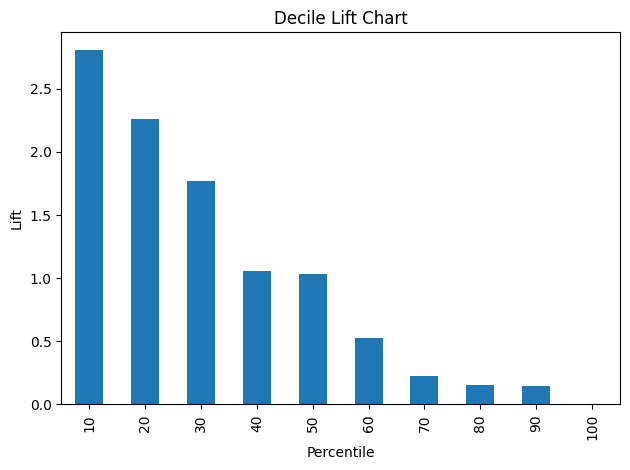

In [ ]:
fig, ax = plt.subplots(1,1)

ax = liftChart(df['actual'], ax=ax, labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout();

Choosing the top 10% of customers most likely to churn, as per our model's predictions, would identify roughly 2.75 more customers than a random subset of 10% chosen at random.

# Trying New Cutoffs

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.metrics import recall_score

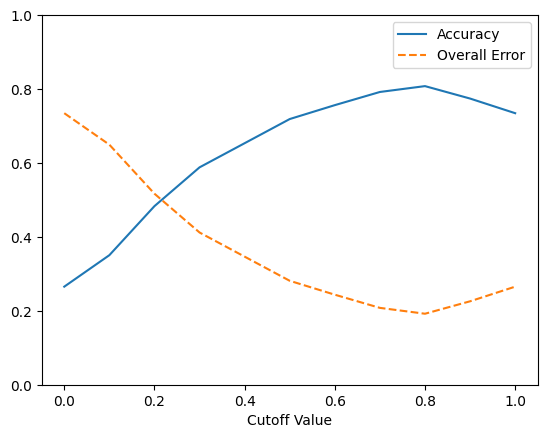

In [ ]:
cutoffs = [i*0.1 for i in range(11)]

accT = []

for cutoff in cutoffs:
  predicted = [1 if p > cutoff else 0 for p in df.prob_churn]
  accT.append(accuracy_score(df.actual, predicted))

line_accuracy = plt.plot(cutoffs, accT, '-', label='Accuracy')
line_error = plt.plot(cutoffs, [1 - acc for acc in accT], '--', label='Overall Error')
plt.ylim([0, 1])
plt.xlabel('Cutoff Value')
plt.legend();

In [ ]:
def classSummary(data, class_summ, cutoff, class_names):
  predicted = [1 if p > cutoff else 0 for p in data.prob_churn]

  class_summ(data.actual, predicted, class_names=class_names)

In [ ]:
# cutoff = 0.5

classSummary(df, classificationSummary, 0.5, ['no churn', 'churn'])

Confusion Matrix (Accuracy 0.7188)

         Prediction
  Actual no churn    churn
no churn      244      127
   churn       15      119


In [ ]:
#cutoff = 0.4

classSummary(df, classificationSummary, 0.4, class_names)

Confusion Matrix (Accuracy 0.6535)

         Prediction
  Actual no churn    churn
no churn      203      168
   churn        7      127


In [ ]:
#cutoff = 0.45

classSummary(df, classificationSummary, 0.45, class_names) #ideal threshold I believe

Confusion Matrix (Accuracy 0.6931)

         Prediction
  Actual no churn    churn
no churn      224      147
   churn        8      126


In [ ]:
#ideal threshold is 0.45

# Cumulative Gains Chart

In [ ]:
from dmba import gainsChart

In [ ]:
df.shape

(505, 3)

In [ ]:
np.arange(1, 506)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [ ]:
df['cumulative_actual_class'] = np.arange(1, 506)

In [ ]:
df = df.assign(
    predicted = [1 if p > 0.45 else 0 for p in df.prob_churn]
)

In [ ]:
df.head()

,predicted,actual,prob_churn,cumulative_actual_class
customerID,,,,
7024-OHCCK,1,1,0.954586,1
4695-WJZUE,1,1,0.942162,2
8884-ADFVN,1,1,0.941698,3
2446-BEGGB,1,1,0.941602,4
1724-BQUHA,1,1,0.940507,5


In [ ]:
classificationSummary(df.actual, df.predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.6931)

         Prediction
  Actual no churn    churn
no churn      224      147
   churn        8      126


In [ ]:
df.to_excel('new_cutoffThresholdWithSortedPropensities.xlsx') # incase needed

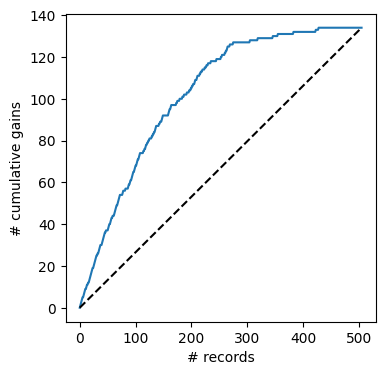

In [ ]:
gainsChart(df.actual, figsize=(4, 4));

## Interpretation: If we were to choose the top 100 customers that are model predicts are most likely to churn, the model would be correct for about 70 of them. If we select 100 customers at random, we would expect to only be right for about 20-25 of them.

## Our Cumulative gains chart gives us a LIFT in detecting the customers that are likely to churn of almost 3!

# At 200 records we still have a lift a little greater than 2.

# Decile Lift Chart

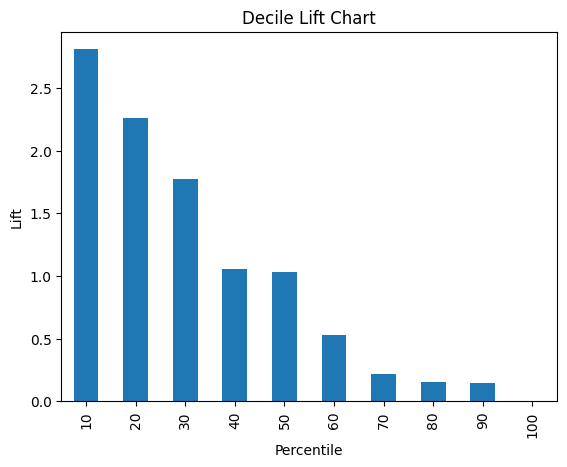

In [ ]:
liftChart(df.actual, labelBars=False);

## The top 10% of customers that are ranked as most likely to churn yields more than 2.5 times as many "churns" as would a random selection of the 10% of the customer records.

## It's certainly worth analyzing the top 30 percentile of customers that are churning at what their features are that are causing them to leave.

# Good idea to put the top 30% of these customers into a Decision Tree visualizer and see how their characteristics interact to determine churn/not churn.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
original_df = pd.read_excel('/content/for_machine_learningdf.xlsx').set_index('customerID')

In [ ]:
df.head()

,predicted,actual,prob_churn,cumulative_actual_class
customerID,,,,
7024-OHCCK,1,1,0.954586,1
4695-WJZUE,1,1,0.942162,2
8884-ADFVN,1,1,0.941698,3
2446-BEGGB,1,1,0.941602,4
1724-BQUHA,1,1,0.940507,5


In [ ]:
original_df.head()

,seniorCitizen,partner,dependents,tenure,phoneService,paperlessBilling,monthlyCharges,totalCharges,gender_Male,multipleLines_True,...,streamingTV_True,streamingTV_No internet service,streamingMovies_True,streamingMovies_No internet service,contract_One year,contract_Two year,paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check,churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,1,29.850000,29.850000,0,0,...,0,0,0,0,0,0,0,1,0,0
5575-GNVDE,0,0,0,34,1,0,56.950001,1889.500000,1,0,...,0,0,0,0,1,0,0,0,1,0
3668-QPYBK,0,0,0,2,1,1,53.849998,108.150002,1,0,...,0,0,0,0,0,0,0,0,1,1
7795-CFOCW,0,0,0,45,0,0,42.299999,1840.750000,1,0,...,0,0,0,0,1,0,0,0,0,0
9237-HQITU,0,0,0,2,1,1,70.699997,151.649994,0,0,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
df.shape

(505, 4)

In [ ]:
merged_df = original_df.join(df.drop(['actual','cumulative_actual_class'], axis=1), how='inner')

In [ ]:
merged_df.head()

,seniorCitizen,partner,dependents,tenure,phoneService,paperlessBilling,monthlyCharges,totalCharges,gender_Male,multipleLines_True,...,streamingMovies_True,streamingMovies_No internet service,contract_One year,contract_Two year,paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check,churn,predicted,prob_churn
customerID,,,,,,,,,,,,,,,,,,,,,
6234-RAAPL,0,1,1,72,1,0,99.900002,7251.700195,0,1,...,0,0,0,1,0,0,0,0,0,0.140468
6572-ADKRS,0,0,0,46,1,1,74.800003,3548.300049,0,0,...,0,0,0,0,1,0,0,0,1,0.636563
5919-TMRGD,0,0,1,1,1,1,79.349998,79.349998,0,0,...,0,0,0,0,0,1,0,1,1,0.899702
2796-NNUFI,0,1,1,46,1,1,19.950001,927.099976,0,0,...,0,1,0,1,0,0,1,0,0,0.111640
2848-YXSMW,0,1,1,72,1,0,19.400000,1363.250000,1,0,...,0,1,0,1,1,0,0,0,0,0.051462


In [ ]:
merged_df.sort_values(by='prob_churn', ascending=False)

,seniorCitizen,partner,dependents,tenure,phoneService,paperlessBilling,monthlyCharges,totalCharges,gender_Male,multipleLines_True,...,streamingMovies_True,streamingMovies_No internet service,contract_One year,contract_Two year,paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check,churn,predicted,prob_churn
customerID,,,,,,,,,,,,,,,,,,,,,
7024-OHCCK,1,0,0,2,1,1,93.849998,170.850006,0,1,...,1,0,0,0,0,1,0,1,1,0.954586
4695-WJZUE,1,0,0,2,1,1,88.550003,179.250000,0,1,...,1,0,0,0,0,1,0,1,1,0.942162
8884-ADFVN,1,1,0,7,1,1,101.950000,700.850000,1,1,...,1,0,0,0,0,1,0,1,1,0.941698
2446-BEGGB,1,0,0,6,1,1,98.250000,560.600000,0,1,...,1,0,0,0,0,1,0,1,1,0.941602
1724-BQUHA,1,0,0,5,1,1,89.500000,477.700012,1,0,...,1,0,0,0,0,1,0,1,1,0.940507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966-SNIZF,0,1,0,70,1,0,19.450001,1303.500000,0,0,...,0,1,0,1,0,0,0,0,0,0.059976
5893-KCLGT,0,0,1,72,1,1,19.750000,1567.000000,0,0,...,0,1,0,1,0,0,1,0,0,0.059625
4957-SREEC,0,1,1,70,1,0,20.350000,1458.100000,1,0,...,0,1,0,1,1,0,0,0,0,0.052999


In [ ]:
merged_df.shape[0]*0.3

151.5

In [ ]:
for_tree = merged_df.iloc[:152] # 30% of the top data

In [ ]:
for_tree.churn.value_counts()

,count
churn,
0,106
1,46


In [ ]:
for_tree.columns

Index(['seniorCitizen', 'partner', 'dependents', 'tenure', 'phoneService',
       'paperlessBilling', 'monthlyCharges', 'totalCharges', 'gender_Male',
       'multipleLines_True', 'multipleLines_No phone service',
       'internetService_DSL', 'internetService_Fiber optic',
       'onlineSecurity_True', 'onlineSecurity_No internet service',
       'onlineBackup_True', 'onlineBackup_No internet service',
       'deviceProtection_True', 'deviceProtection_No internet service',
       'techSupport_True', 'techSupport_No internet service',
       'streamingTV_True', 'streamingTV_No internet service',
       'streamingMovies_True', 'streamingMovies_No internet service',
       'contract_One year', 'contract_Two year',
       'paymentMethod_Credit card (automatic)',
       'paymentMethod_Electronic check', 'paymentMethod_Mailed check', 'churn',
       'predicted', 'prob_churn'],
      dtype='object')

In [ ]:
X = for_tree.drop(['partner', 'predicted', 'prob_churn', 'churn'], axis=1)

In [ ]:
y = for_tree.churn

In [ ]:
dt = DecisionTreeClassifier(random_state=0,)

In [ ]:
param_grid = {
    'max_depth': list(range(1,13,2)),
    'min_samples_split': list(range(2, 17, 2)),
    'min_impurity_decrease': [0, 0.001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
}

In [ ]:
dt_grid = GridSearchCV(
    dt, param_grid, n_jobs=-1
)

In [ ]:
dt_grid.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11],
                         'min_impurity_decrease': [0, 0.001, 0.005, 0.001,
                                                   0.005, 0.01, 0.05, 0.1,
                                                   0.5],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16]})

In [ ]:
from dmba import plotDecisionTree

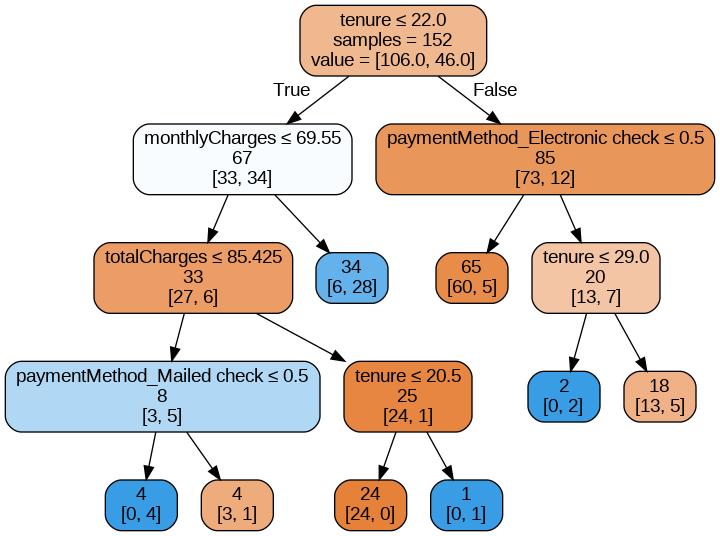

In [ ]:
plotDecisionTree(dt_grid.best_estimator_, feature_names=X.columns)

## NOTEABLE ANALYSIS OF THE TOP 30% of customers that have been identified as "most likely to churn".

Definiting Characteristics:
 - Customers that have been with Telco less than or equal to 22 months and have monthly charges more than $69.50 are more likely to churn.

 **NOTE**: As identified earlier, worth seeing if these customers have FIBER OPTIC with the company. likely unhappy with it.

In [ ]:
merged_df.columns = [col.replace(' ','_') for col in merged_df.columns]

In [ ]:
merged_df.iloc[:152].query("tenure <=22 & monthlyCharges>69.55 & predicted==1 & internetService_Fiber_optic==1")

,seniorCitizen,partner,dependents,tenure,phoneService,paperlessBilling,monthlyCharges,totalCharges,gender_Male,multipleLines_True,...,streamingMovies_True,streamingMovies_No_internet_service,contract_One_year,contract_Two_year,paymentMethod_Credit_card_(automatic),paymentMethod_Electronic_check,paymentMethod_Mailed_check,churn,predicted,prob_churn
customerID,,,,,,,,,,,,,,,,,,,,,
5919-TMRGD,0,0,1,1,1,1,79.349998,79.349998,0,0,...,0,0,0,0,0,1,0,1,1,0.899702
0404-SWRVG,0,0,0,3,1,1,74.400002,229.550003,1,1,...,0,0,0,0,0,1,0,1,1,0.911743
3874-EQOEP,0,0,0,7,1,0,95.000000,655.500000,1,1,...,1,0,0,0,0,0,1,1,1,0.893088
0867-MKZVY,0,1,0,20,1,0,82.400002,1592.349976,0,1,...,0,0,0,0,0,1,0,1,1,0.773444
3376-BMGFE,0,0,0,4,1,1,70.900002,273.000000,0,0,...,0,0,0,0,0,0,0,1,1,0.851323
2604-IJPDU,0,1,0,20,1,1,96.550003,1901.650024,0,0,...,0,0,0,0,0,1,0,0,1,0.711710
9903-LYSAB,0,1,0,18,1,1,73.150002,1305.949951,1,1,...,0,0,0,0,0,1,0,0,1,0.877167
5940-AHUHD,0,0,0,1,1,0,70.599998,70.599998,1,0,...,0,0,0,0,0,0,1,1,1,0.827410
2868-SNELZ,0,0,0,2,1,0,80.599998,155.800003,0,1,...,0,0,0,0,0,0,1,1,1,0.838224


In [ ]:
merged_df.iloc[:152].query("tenure <=22 & monthlyCharges>69.55 & predicted==1 & internetService_Fiber_optic==1").churn.value_counts()

,count
churn,
1,27
0,5


We see here that 32 of the 34 samples that followed that logical rule **DID INDEED HAVE FIBER OPTIC SERVICE** purchased from the company. The Fiber Optic service is very likely the problem.

We also see that 27 of the 32 customers that did purchase the Fiber Optic Internet service did in fact leave.

#Last thing (do whenever): Try and see how model performs on unseen data (The Kaggle Data).

